# Xerces2-j
by Jerelyn Co (Jan 2018)

Main Reference: Kumar, L., & Sureka, A. (2017). Application of LSSVM and SMOTE on Seven Open Source Projects for Predicting Refactoring at Class Level. Asia-Pacific Software Engineering Conference (APSEC 2017), 90–99. https://doi.org/10.1109/APSEC.2017.15

In [97]:
import os

import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.model_selection import KFold,train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import svm

from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve, auc, roc_auc_score, average_precision_score

from collections import Counter


%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


/home/jerelyn/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Classification Utils

In [2]:
def get_inputs(data, features, label, binary_csf=True):
    if binary_csf:
        raw_X, y = data[features], data[label]
    else:
        # Label encoding for refactoring types. Transforming categorical labels to 0 to n_classes - 1.
        le = preprocessing.LabelEncoder()
        le.fit(data[label])
        data[label] = le.transform(data[label])
        raw_X, y = data[features], data[label]
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(raw_X)
    return X, y.values.ravel()

In [3]:
def metrics_report(est, true, pred):
    print('Model Report:')
    print(classification_report(true, pred))

    fp_rate, tp_rate, thresholds = roc_curve(true, pred)
    print("AUC: {}".format(auc(fp_rate, tp_rate)))
    print("Accuracy Report: {}".format(accuracy_score(true, pred) * 100))

In [4]:
def prc(est, X_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, est.predict_proba(X_test)[:,1])
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    return 1

In [5]:
def feature_importances(est, features):
    importances = est.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(features)), importances[indices],
           color="r", align="center")
    
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation="vertical")
    plt.xlim([-1, len(features)])
    plt.show()
    
    return [features[i] for i in indices]

In [6]:
def XGB(X_train, y_train, X_test, y_test, param_test):
    n_neg, n_pos = np.bincount(y_test)
    clf_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", eval_metric="map",
                                                       scale_pos_weight=n_neg/n_pos, num_boost_round=999,
                                                       early_stopping_round=10,seed=RAND_STATE, nthread=1), 
                          param_grid=param_test, cv=CV)

    mod = clf_xgb.fit(X_train, y_train)
    y_true, y_pred = y_test, mod.predict(X_test)

    metrics_report(clf_xgb.best_estimator_, y_test, y_pred)
    return clf_xgb.best_estimator_, y_true, y_pred
    

In [7]:
def svc(X_train, y_train, X_test, y_test, param_test):
    clf_svc = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_test, cv=CV)
    mod = clf_svc.fit(X, y)
    y_true, y_pred = y_test, mod.predict(X_test)
    
    metrics_report(clf_svc.best_estimator_, y_test, est.predict(X_test))
    return clf_svc.best_estimator_, y_true, y_pred

In [8]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

### Load Datasets

In [75]:
ant_dir = "data/raw/badsmells/data/apache-ant/apache-ant/"
xerces_dir = "data/raw/badsmells/data/apache-ant/xerces-j/"

ddata_dir = "data/transformed/"

In [76]:
data_df_csf = pd.read_csv(ddata_dir+"proc_prod.csv")
# Create a binary label column.
data_df_csf["w_ref"] = data_df_csf["Refactoring"].apply(lambda x: 0 if x =="not" else 1)
data_df_csf.head()

,Refactoring,Version_x,Class,AG,NDC,ADD,DEL,CHURN,nsplit,Version_y,...,ComplexClass,LazyClass,LongMethod,LongParameterList,MessageChain,RPB,SpaghettiCode,SpeculativeGenerality,FeatureEnvy,w_ref
0,not,1.5,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0
1,not,1.5,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.7.1,...,0,0,0,0,0,0,0,0,0,0
2,not,1.5.4,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0
3,not,1.5.4,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.7.1,...,0,0,0,0,0,0,0,0,0,0
4,not,1.5,main.org.apache.tools.ant.filters.LineContains,30192410,3,19.0,11.0,1911.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0


In [77]:
info_cols = ['Version_x',  'Version_y', 'Class', 'nsplit']
bin_label = ['w_ref']
multi_label = ["Refactoring"]
proc_cols = ['AG', 'NDC', 'ADD', 'DEL', 'CHURN']
prod_cols = ['LOC', 'WMC', 'DIT', 'NOC', 'RFC','CBO', 'LCOM', 'NOM', 'NOA', 'NOO', 'CCBC', 'C3']
bs_cols = ['BLOB', 'CDSBP', 'ComplexClass', 'LazyClass', 'LongMethod', 'LongParameterList', 'MessageChain', 'RPB',
           'SpaghettiCode', 'SpeculativeGenerality', 'FeatureEnvy',]

In [78]:
data_df_csf.dropna(inplace=True)
data_df_csf.drop_duplicates(inplace=True)

In [79]:
data_df_csf.groupby(["proj", "w_ref"])["Class"].count()

proj        w_ref
apache-ant  0          389
            1          205
xerces2-j   0        53754
            1         1354
Name: Class, dtype: int64

## Binary Classification

In [14]:
TEST_SIZE = 0.3
RAND_STATE = 12
CV = 5

In [15]:
svc_param_grid = {'C': [0.01, 0.1, 5], 'gamma' : [0.001, 0.01, 0.1, 1]}
xgb_param_grid = {
    'n_estimators':[100,150,200],
    'max_depth': [6, 9, 12],
}

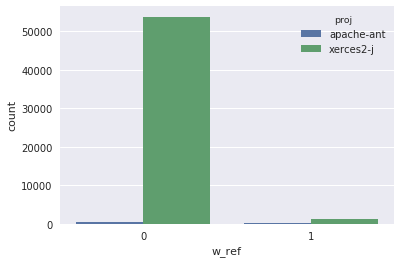

In [16]:
ax = sns.countplot(x="w_ref", data=data_df_csf, hue="proj")

Use of PRC 

Saito, T., & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PLoS ONE, 10(3), 1–21. https://doi.org/10.1371/journal.pone.011843

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/

Data is severely screwed to the negative class (without refactoring). 

Application of SMOTE to balance this severely screwed data may not be a good idea.

Try out cluster centroids.
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.ClusterCentroids.html

In [91]:
proj = "xerces2-j"
data_df_csf = data_df_csf[data_df_csf["proj"]==proj]

In [92]:
features = prod_cols + proc_cols 
X, y = get_inputs(data_df_csf, features, bin_label)

In [93]:
rcParams['figure.figsize'] = 10,10

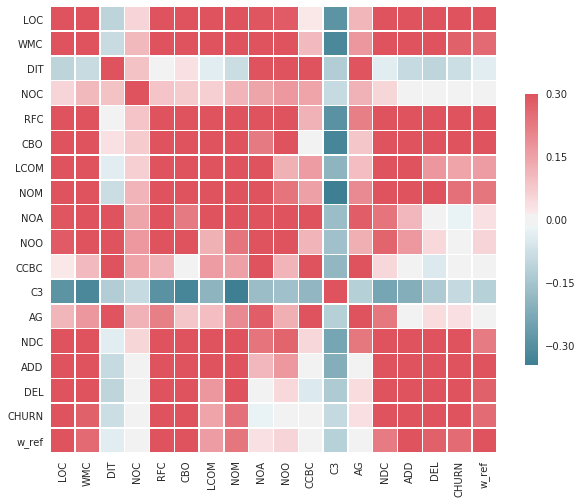

In [94]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_df_csf[features+bin_label].corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

## Using XGBoost

[Kaggle Introduction](https://www.kaggle.com/babatee/intro-xgboost-classification)

http://xgboost.readthedocs.io/en/latest//parameter.html

http://xgboost.readthedocs.io/en/latest//how_to/param_tuning.html

### All features

In [98]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

res = sm.Logit(y_train, X_train).fit()

print(res.summary())
OR = np.exp(res.params)

Optimization terminated successfully.
         Current function value: 0.086052
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38575
Model:                          Logit   Df Residuals:                    38558
Method:                           MLE   Df Model:                           16
Date:                Mon, 15 Jan 2018   Pseudo R-squ.:                  0.2583
Time:                        15:05:50   Log-Likelihood:                -3319.4
converged:                       True   LL-Null:                       -4475.3
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1919      0.406     -0.472      0.637      -0.988       0.604
x2             3.8329      1

<BarContainer object of 17 artists>

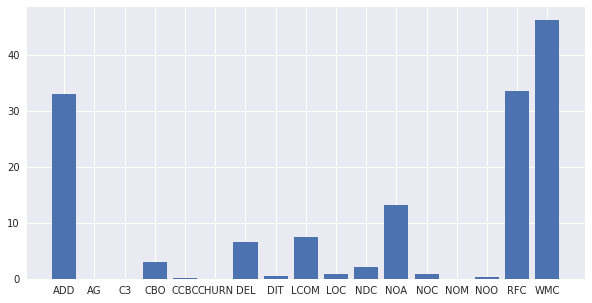

In [99]:
plt.bar(x=features, height=OR)

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     16134
          1       0.28      0.84      0.41       399

avg / total       0.98      0.94      0.96     16533

AUC: 0.8936260789571548
Accuracy Report: 94.26601342769007


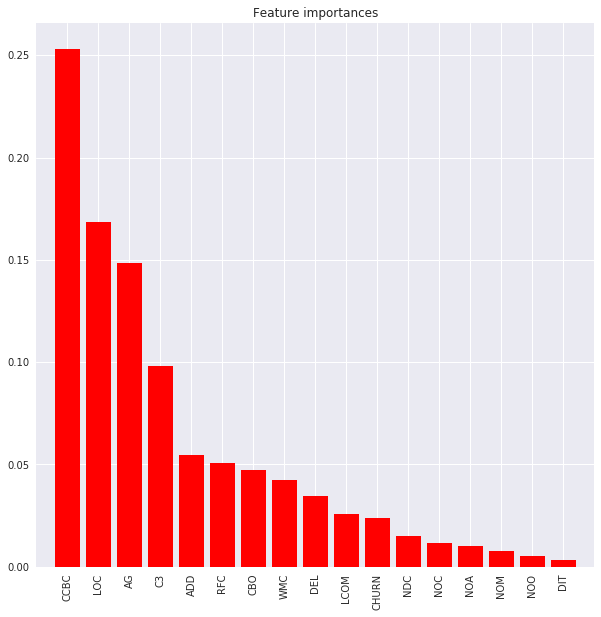

CPU times: user 5min 21s, sys: 344 ms, total: 5min 21s
Wall time: 5min 21s


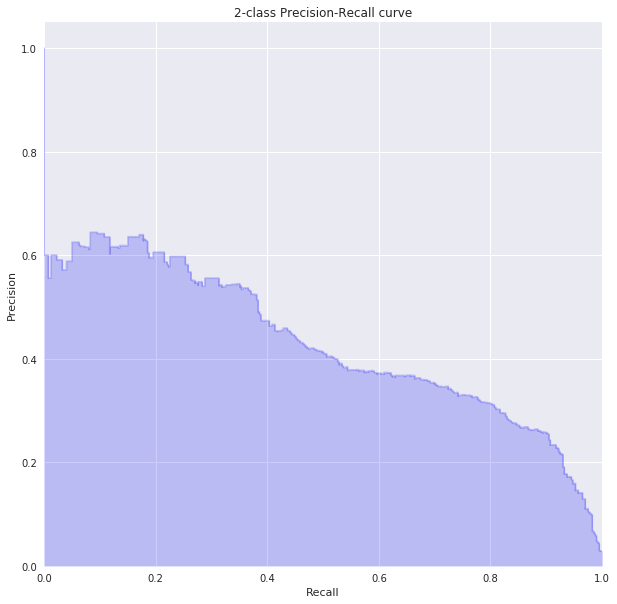

In [89]:
%%time
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
feature_ranks = feature_importances(est, features)
prc(est, X_test, y_test)

Let's try to reduce features by using the RF's built-in feature importances

### Reduced features

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     16134
          1       0.28      0.84      0.42       399

avg / total       0.98      0.94      0.96     16533

AUC: 0.8948482213342952
Accuracy Report: 94.26601342769007
CPU times: user 2min 32s, sys: 276 ms, total: 2min 32s
Wall time: 2min 33s


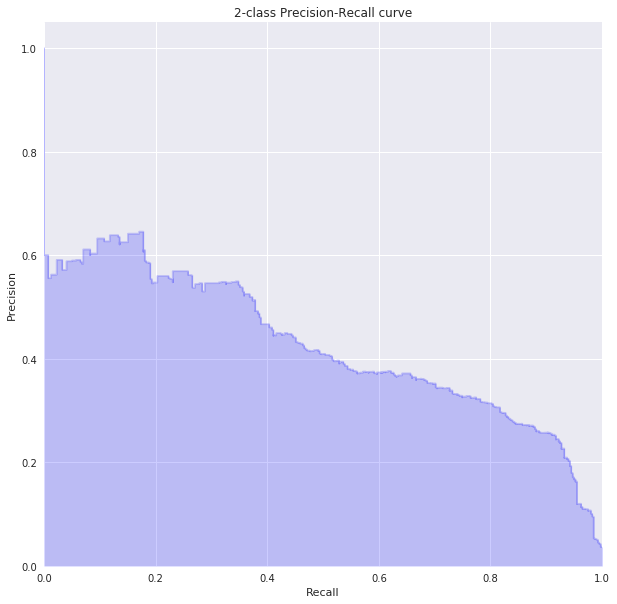

In [38]:
%%time
top_features = [i for i in feature_ranks[:4]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

### Product Metrics only

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     16134
          1       0.27      0.93      0.42       399

avg / total       0.98      0.94      0.95     16533

AUC: 0.9327616642946152
Accuracy Report: 93.79422972237343
CPU times: user 4min 17s, sys: 271 ms, total: 4min 18s
Wall time: 4min 18s


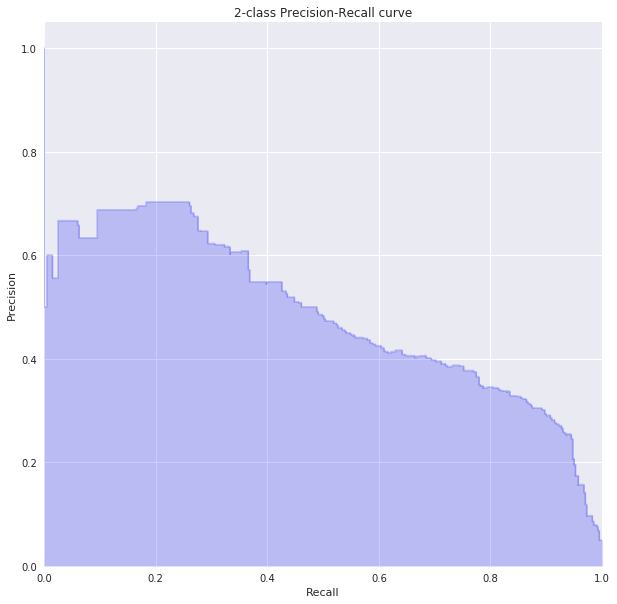

In [40]:
%%time
top_features = prod_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

### Process Metrics only

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.88      0.93     16134
          1       0.15      0.90      0.26       399

avg / total       0.98      0.88      0.92     16533

AUC: 0.8867026249148345
Accuracy Report: 87.66709006229965
CPU times: user 2min 34s, sys: 188 ms, total: 2min 34s
Wall time: 2min 34s


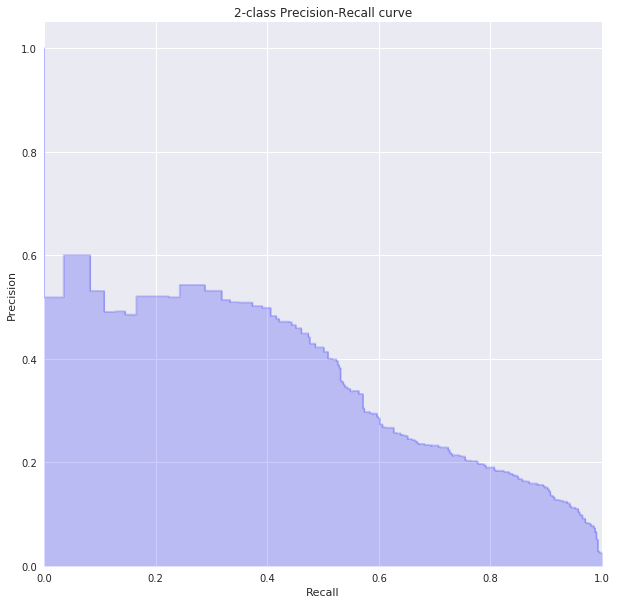

In [42]:
%%time
top_features = proc_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

### Applying SMOTE to dataset. 
As we have seen during our data exploration, the dataset is severely imbalanced.

Reference: [Becker](https://www.google.co.jp/search?client=ubuntu&channel=fs&q=ROC+auc+curve+in+python&ie=utf-8&oe=utf-8&gfe_rd=cr&dcr=0&ei=EE1UWuPXNcyQ8QfT1YbAAw)

Let's try again

In [80]:
features = prod_cols + proc_cols + bs_cols
X, y = get_inputs(data_df_csf, features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)


[37870  1121]
[37870 22722]
CPU times: user 212 ms, sys: 4.02 ms, total: 216 ms
Wall time: 215 ms


/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


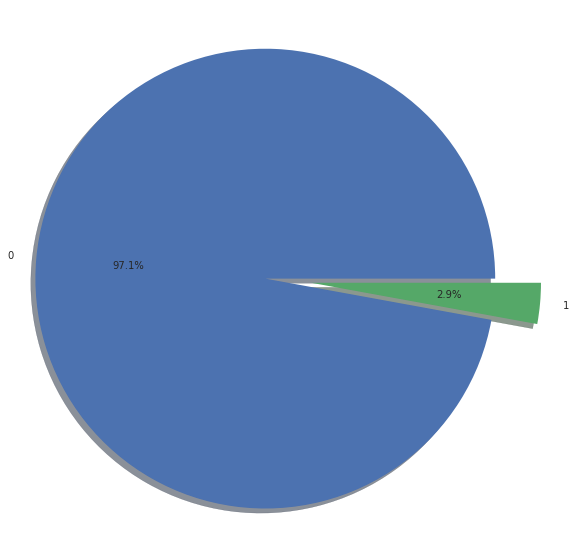

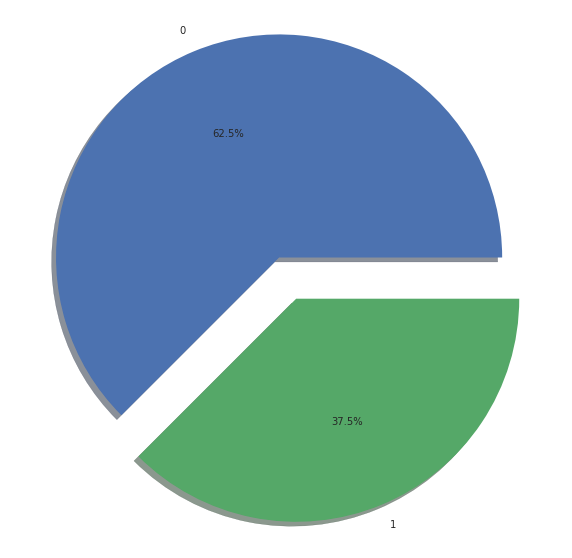

In [81]:
%%time

plot_pie(y_train)
print(np.bincount(y_train))
sm = SMOTE(random_state=RAND_STATE, ratio=0.6)
X_train, y_train = sm.fit_sample(X_train, y_train)
print(np.bincount(y_train))
plot_pie(y_train)


Model Report:
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     16134
          1       0.27      0.85      0.41       399

avg / total       0.98      0.94      0.96     16533

AUC: 0.8949856977885396
Accuracy Report: 94.05431561120184


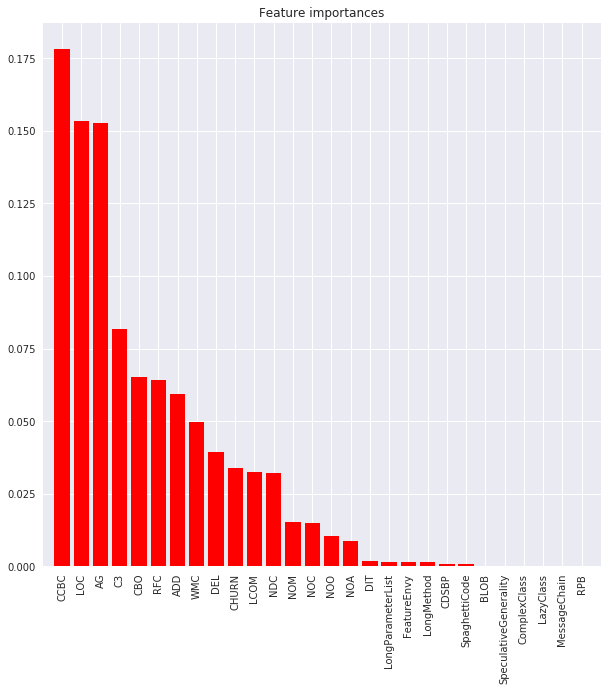

1

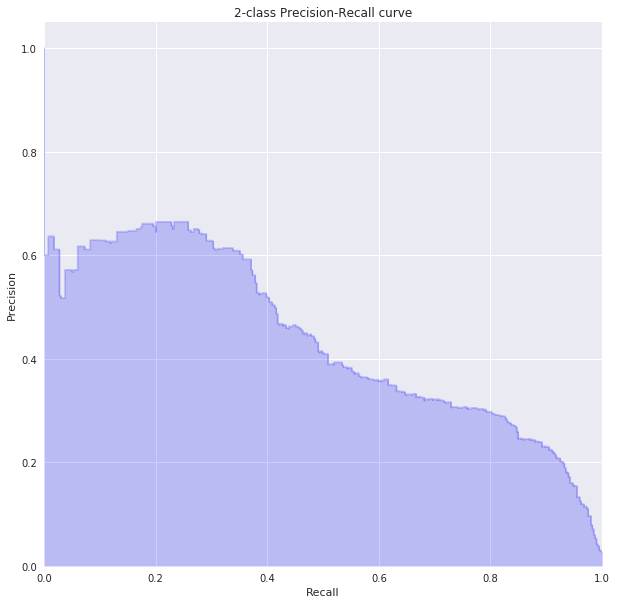

In [73]:
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
feature_ranks = feature_importances(est, features)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     16134
          1       0.28      0.84      0.42       399

avg / total       0.98      0.94      0.96     16533

AUC: 0.8948482213342952
Accuracy Report: 94.26601342769007
CPU times: user 2min 18s, sys: 172 ms, total: 2min 18s
Wall time: 2min 18s


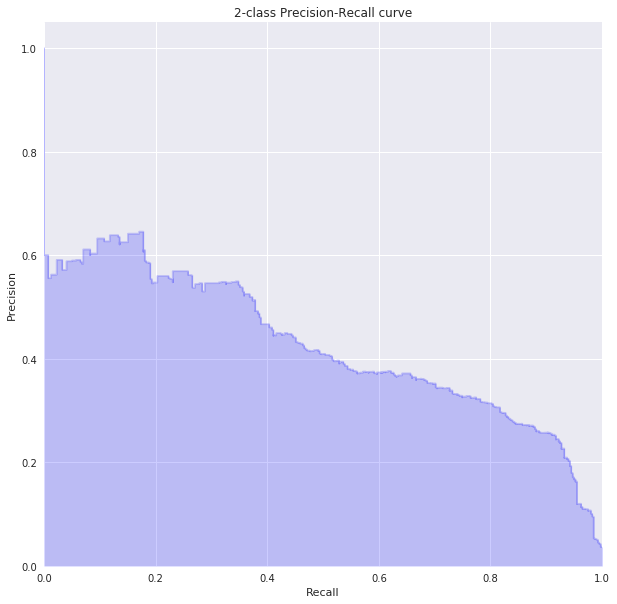

In [63]:
%%time
top_features = [i for i in feature_ranks[:4]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     16134
          1       0.27      0.93      0.42       399

avg / total       0.98      0.94      0.95     16533

AUC: 0.9327616642946152
Accuracy Report: 93.79422972237343
CPU times: user 4min 8s, sys: 252 ms, total: 4min 9s
Wall time: 4min 9s


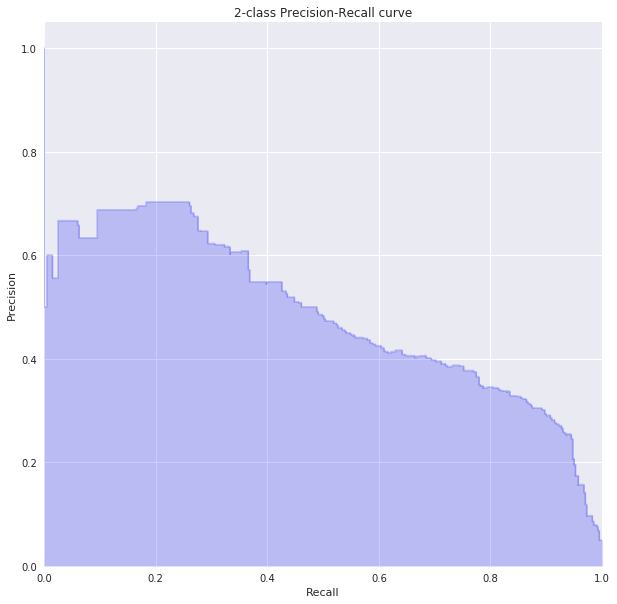

In [65]:
%%time
top_features = prod_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       1.00      0.88      0.93     16134
          1       0.15      0.90      0.26       399

avg / total       0.98      0.88      0.92     16533

AUC: 0.8867026249148345
Accuracy Report: 87.66709006229965
CPU times: user 2min 27s, sys: 216 ms, total: 2min 27s
Wall time: 2min 27s


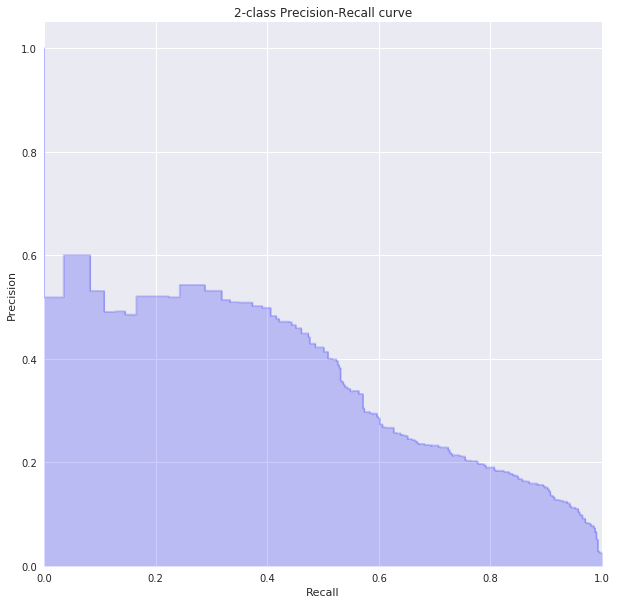

In [64]:
%%time
top_features = proc_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

In [ ]:
# Apply Cluster Centroids
cc = ClusterCentroids()
X_train_res, y_train_res = cc.fit_sample(X_train, y_train)

## What was done
- Multi-class prediction

## Preliminary Findings

- Despite the innate capability of tree-based algorithms to somehow compensate for unbalanced datasets, resampling has to be done in this specific application because of the severely unbalanced dataset. If we don't, then training would be problematic as there will be some classes that may be severely under-represented / zero.

## What else can be done

- Try out binary classification
- Hyperparameter tuning in XGBoost
- ROC AUC Curves
- Confusion Matrix
- Feature selection using the results of the algorithms' features significance
- Compare XGBoost's performance

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

# Apply Cluster Centroids
cc = ClusterCentroids()
X_res, y_res = cc.fit_sample(X, y)
X_res_vis = pca.transform(X_res)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_res == 0, 0],
            X_res_vis[y_res == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis[y_res == 1, 0],
            X_res_vis[y_res == 1, 1],
            label="Class #1", alpha=.5)
c2 = ax2.scatter(X_vis[y == 1, 0],
                 X_vis[y == 1, 1], label="Original #1",
                 alpha=0.2)
ax2.set_title('Cluster centroids with soft voting')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

plt.figlegend((c0, c1), ('Class #0', 'Class #1', 'Original Class #1'),
              loc='lower center',
              ncol=3, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()